In [1]:
import torch
import random
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from os import listdir
from os.path import join
from random import shuffle
from transformers import AdamW
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler
from pdb import set_trace as breakpoint
from nltk.stem.snowball import SnowballStemmer
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration

In [2]:
%matplotlib inline

In [3]:
# folders = ['bags_and_cases', 'bluetooth', 'boots', 'keyboards', 'tv', 'vacuums']

# base_dir = '/mnt/nfs/work1/hongyu/brawat/amzn/oposum/data/seeds'

# list_aspects = []
# Aspect_to_seeds = {}
# stemmer = SnowballStemmer(language='english')
# for each_folder in folders:
#     folder_dir = join(base_dir, each_folder)
#     print('--'*20)
#     print(each_folder)
#     print('--'*20)
#     txt_files = listdir(folder_dir)
#     txt_files = [x for x in txt_files if 'None' not in x]
#     print(txt_files)
#     for each_txt in txt_files:
#         txt_dir = join(folder_dir, each_txt)
#         txt = open(txt_dir).read()
#         txt = txt.split('\n')
#         txt = [x.split(' ')[-1] for x in txt]
#         txt = [x.strip() for x in txt]
#         txt = [stemmer.stem(x) for x in txt]
#         aspect = each_txt.split('.')[1]
#         Aspect_to_seeds[aspect] = txt

In [4]:
# for each_aspect in Aspect_to_seeds:
#     print(each_aspect, Aspect_to_seeds[each_aspect].__len__())

In [5]:
# pkl.dump(Aspect_to_seeds, open('Aspect_to_seeds_march19.pkl', 'wb'))

In [6]:
Aspect_to_seeds = pkl.load(open('Aspect_to_seeds_march19.pkl', 'rb'))

In [7]:
Aspect_to_seeds

{'Compartments': ['pocket',
  'cabl',
  'compart',
  'outsid',
  'lot',
  'wish',
  'wallet',
  'connector',
  'space',
  'power',
  'pen',
  'folder',
  'charger',
  'flap',
  'mous',
  'nice',
  'thing',
  'insid',
  'small',
  'paperwork',
  'accessori',
  'daytim',
  'jacket',
  'raincoat',
  'nois',
  'reduct',
  'earphon',
  'munchi',
  'construct',
  'medium',
  'player',
  'wire',
  'run',
  'headphon',
  'key',
  'instead',
  'huge',
  'need',
  'open',
  'fit',
  'headset',
  'outer',
  'planner',
  'safe',
  'adapt',
  'remot',
  'control',
  'cellphon',
  'save',
  'document',
  ''],
 'Price': ['price',
  'money',
  'feaur',
  'paid',
  'spin',
  'spun',
  'mayb',
  'cheap',
  '200',
  'spend',
  'right',
  'vaccum',
  'twice',
  'expect',
  'pricey',
  '50',
  'expens',
  'worth',
  'far',
  'wast',
  'duster',
  'think',
  'bagless',
  'best',
  'dyson',
  'need',
  'ok',
  'weight',
  'bag',
  'power',
  'light',
  'like',
  'good',
  'vacuum',
  ''],
 'Handles': ['strap

In [8]:
for each_aspect in Aspect_to_seeds:
    print(each_aspect, Aspect_to_seeds[each_aspect].__len__())

Compartments 51
Price 35
Handles 51
Customer_service 51
Looks 23
Quality 51
Protection 50
Size_Fit 51
Ease_of_use 51
Sound 51
Look 51
Connectivity 51
Battery 49
Durability 51
Comfort 51
Materials 51
Color 20
Size 51
Weather_resistance 51
Noise 51
Extra_functionality 51
Layout 51
Feel_Comfort 51
Build_Quality 51
Size_Look 51
Image 51
Apps_Interface 48
Suction_Power 51
Weight 51
Customer_Service 49
Accessories 51


In [9]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

In [10]:
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [11]:
# !echo $CUDA_VISIBLE_DEVICES

In [12]:
model_args = {'seed_samples': 10, 
              'aspect_length':6
             }

In [13]:
class aspectDataset(Dataset):
    
    def __init__(self, list_data, tokenizer, model_args):
        self.tokenizer = tokenizer
        self.list_data = list_data
        self.seeds_length = model_args['seed_samples']
        self.aspect_length = model_args['aspect_length']
    
    def __len__(self):
        """Return length of dataset."""
        return self.list_data.__len__()

    def __getitem__(self, i):
        """Return sample from dataset at index i."""
        example = self.list_data[i]
        shuffle(example['seeds'])
        sampled_seeds = example['seeds'][:self.seeds_length]
        aspect = " ".join(example["aspect"].split('_'))
#         max_length = self.seeds_length+2
        inputs = tokenizer(", ".join(sampled_seeds), 
                           truncation=True)  
#         inputs = tokenizer(", ".join(sampled_seeds), 
#                            padding="max_length", 
#                            truncation=True, 
#                            max_length=max_length)  
        outputs = tokenizer(aspect, 
                            padding="max_length", 
                            truncation=True, 
                            max_length=self.aspect_length)
        
        batch = {}
        batch["input_ids"] = torch.LongTensor(inputs.input_ids)
        batch["attention_mask"] = torch.LongTensor(inputs.attention_mask)
        batch["decoder_input_ids"] = torch.LongTensor(outputs.input_ids)
        batch["decoder_attention_mask"] = torch.LongTensor(outputs.attention_mask)
        batch["labels"] = outputs.input_ids.copy()
        batch['labels'] = [batch['labels']]

        # We have to make sure that the PAD token is ignored for calculating the loss
        batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] 
                           for labels in batch["labels"]]
        batch["labels"] = torch.LongTensor(batch["labels"])
        
        return batch

In [14]:
train_data = []
for each_key in Aspect_to_seeds:
    train_data.append({"seeds":Aspect_to_seeds[each_key],
                       "aspect":each_key})

In [15]:
train_dataset = aspectDataset(list_data=train_data, 
                              tokenizer=tokenizer,
                              model_args=model_args
                             )

In [16]:
train_loader = DataLoader(train_dataset, 
                          batch_size=1, 
                          shuffle=True,
                          num_workers=1)

In [17]:
model = model.to("cuda")

In [18]:
# the_encoder = model.get_encoder()
# the_decoder = model.get_decoder()
# last_linear_layer = model.lm_head

In [19]:
num_epochs = 15
num_training_steps = num_epochs * len(train_data)

loss_fct = CrossEntropyLoss()

optimizer = AdamW(model.parameters(), 
                  lr=1e-6)
warmup_steps = int(0.10*num_training_steps)
lr_scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=warmup_steps,
                            num_training_steps=num_training_steps
                            )

In [20]:
all_train_loss = []
for epoch in tqdm(range(num_epochs)):
    training_loss = 0.0
    model.train()
    for ind, batch in enumerate(train_loader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        
        model_op = model(**batch)
        loss = model_op['loss']
        
        training_loss += loss.item()
        
        print('---'*20)
        print('ID:', ind)
        print('---'*20)
        print('Seed words:', tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
        print('Actual aspect:', tokenizer.batch_decode(batch['decoder_input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
        output_ids = model.generate(batch["input_ids"], num_beams=3, max_length=6)
        print('Predicted aspect:', tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True))
        
        loss.backward()
        optimizer.step() 
        lr_scheduler.step() 
        optimizer.zero_grad() 
    training_loss = training_loss / len( train_data )
    all_train_loss.append(training_loss)
    print("Epoch {}:\tTraining Loss {:.2f}".format(epoch+1, training_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['basic, complet, sensor, clean, regular, way, replac, instead, bag, rotat']
Actual aspect: ['Accessories']
Predicted aspect: ['basic, comple']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['bit, nois, seat, enorm, bare, m1710, te, hp, cabl, space']
Actual aspect: ['Size Fit']
Predicted aspect: ['bit, no']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['disk, handi, sleep, low, label, brower, recess, program, custom, multimedia']
Actual aspect: ['Extra functionality']
Predicted aspect: ['disk, hand']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['short, carpet, imposs, 

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['attract, nice, look, style, airi, smooth, grey, offic, fring, hang']
Actual aspect: ['Look']
Predicted aspect: ['attract,']


  7%|▋         | 1/15 [00:13<03:15, 13.97s/it]

Epoch 1:	Training Loss 4.97
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['cubbyhol, actual, smaller, big, livingroom, perfect, hardwar, 32, light, 60']
Actual aspect: ['Size Look']
Predicted aspect: ['cubbyhol']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['spill, layout, size, , insert, impecc, chang, horizont, multimedia, bar']
Actual aspect: ['Layout']
Predicted aspect: ['spill,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['broken, adapt, month, comfort, torn, minut, loop, short, buckl, lift']
Actual aspect: ['Handles']
Predicted aspect: ['broken, adapt']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['sou

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['bar, watt, worthi, strain, junki, speaker, tinni, dinner, quieter, sound']
Actual aspect: ['Sound']
Predicted aspect: ['bar, watt']


 13%|█▎        | 2/15 [00:26<02:46, 12.83s/it]

Epoch 2:	Training Loss 3.08
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['got, cold, den, soak, soak, spent, defect, item, ice, grass']
Actual aspect: ['Weather resistance']
Predicted aspect: ['got, cold']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['let, best, especi, penetr, superb, elast, fashion, friction, rubber, aerosol']
Actual aspect: ['Materials']
Predicted aspect: ['let, best']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['month, easili, overh, time, unannounc, built, break, fail, pop, roller']
Actual aspect: ['Build Quality']
Predicted aspect: ['month, eas']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed wo

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['dhcp, watch, play, input, integr, hard, connect, end, comcast, connect']
Actual aspect: ['Connectivity']
Predicted aspect: ['dhcp,']


 20%|██        | 3/15 [00:37<02:26, 12.17s/it]

Epoch 3:	Training Loss 2.11
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['look, blue, love, style, unbeliev, red, , perfect, wonder, favorit']
Actual aspect: ['Color']
Predicted aspect: ['look,']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['laptop, origin, imac, backlit, beauti, appear, keyboard, decent, look, feel']
Actual aspect: ['Looks']
Predicted aspect: ['laptop,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['heavi, loud, compar, especi, quit, vacuum, feel, consid, vaccuum, hard']
Actual aspect: ['Weight']
Predicted aspect: ['heavi,']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['struck, corner, right

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['snug, longer, time, wear, foot, comfi, insid, light, , uncomfort']
Actual aspect: ['Comfort']
Predicted aspect: ['snug']


 27%|██▋       | 4/15 [00:48<02:07, 11.61s/it]

Epoch 4:	Training Loss 1.34
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['comput, let, stream, like, samsung, speed, featur, netflix, friend, easili']
Actual aspect: ['Apps Interface']
Predicted aspect: ['comput,']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['nokia, charger, charg, sudden, turn, get, star, bizarr, pretti, red']
Actual aspect: ['Battery']
Predicted aspect: ['nokia,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['perfom, pretti, good, power, hair, object, attribut, reason, plush, suck']
Actual aspect: ['Suction Power']
Predicted aspect: ['perf']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['de

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['big, baggi, joint, decid, calf, tight, bacaus, advic, ankl, size']
Actual aspect: ['Size']
Predicted aspect: ['big,']


 33%|███▎      | 5/15 [00:59<01:53, 11.38s/it]

Epoch 5:	Training Loss 1.22
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['strong, terribl, tinni, qualiti, volum, , vibrat, display, eye, muffl']
Actual aspect: ['Sound']
Predicted aspect: ['strong,']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['later, good, simpl, vari, recharg, charg, cell, charg, dead, start']
Actual aspect: ['Battery']
Predicted aspect: ['later, good']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['amazon, unfortun, gotten, wait, told, smell, issu, purchas, hour, help']
Actual aspect: ['Customer Service']
Predicted aspect: [', purch']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['impecc, 

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['power, difficult, roller, pile, constant, retractor, flash, furnitur, propel, maneuv']
Actual aspect: ['Ease of use']
Predicted aspect: ['power,']


 40%|████      | 6/15 [01:10<01:40, 11.22s/it]

Epoch 6:	Training Loss 0.93
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['main, dosen, simpic, angl, ergorapido, superb, fair, power, machin, job']
Actual aspect: ['Suction Power']
Predicted aspect: ['main, d']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['calm, fring, weight, collaps, nice, natur, comfort, casual, light, absolut']
Actual aspect: ['Look']
Predicted aspect: ['calm,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['volum, strong, horribl, tinni, develop, worthi, great, strain, vibrat, muffl']
Actual aspect: ['Sound']
Predicted aspect: ['volum is']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['lab

Actual aspect: ['Handles']
Predicted aspect: ['later, month']
------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['hard, fi, like, end, signal, work, audio, cabl, file, output']
Actual aspect: ['Connectivity']
Predicted aspect: ['hard, fi']


 47%|████▋     | 7/15 [01:21<01:29, 11.15s/it]

Epoch 7:	Training Loss 0.77
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['60, wonder, smaller, love, livingroom, lightweight, actual, oh, room, cubbyhol']
Actual aspect: ['Size Look']
Predicted aspect: ['60, wonder']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['small, navig, scroll, squish, place, space, backspac, cluster, place, space']
Actual aspect: ['Layout']
Predicted aspect: [' is a']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['corner, bright, look, eye, nice, sharp, notic, font, excel, black']
Actual aspect: ['Image']
Predicted aspect: ['Corner,']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['spillp

Predicted aspect: ['maneu']
------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['look, cheap, attract, pc, appear, decent, slim, backlit, feel, ']
Actual aspect: ['Looks']
Predicted aspect: ['look,']


 53%|█████▎    | 8/15 [01:31<01:16, 10.94s/it]

Epoch 8:	Training Loss 0.63
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['unfortun, amazon, day, told, absolut, look, contact, common, wait, purchas']
Actual aspect: ['Customer Service']
Predicted aspect: [',']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['love, look, love, , style, gorgeous, wonder, exact, look, favorit']
Actual aspect: ['Color']
Predicted aspect: ['love,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['expens, cup, hepa, cover, empti, onboard, attach, brush, turn, allow']
Actual aspect: ['Accessories']
Predicted aspect: ['expens,']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['mayb, normal, 

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['volum, great, adjust, quieter, surround, whine, true, loudest, realli, shippabl']
Actual aspect: ['Sound']
Predicted aspect: [', loud']


 60%|██████    | 9/15 [01:42<01:05, 10.92s/it]

Epoch 9:	Training Loss 0.63
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['good, expect, 200, ok, price, mayb, duster, spend, vaccum, like']
Actual aspect: ['Price']
Predicted aspect: ['good, expect']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['shut, sturdi, turn, wise, bump, , burn, turn, fail, constuct']
Actual aspect: ['Build Quality']
Predicted aspect: ['shut, st']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['normal, drop, construct, use, pad, probabl, thing, larg, lap, provid']
Actual aspect: ['Protection']
Predicted aspect: ['normal, drop']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['prefer, power, 

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['penetr, especi, back, porous, decor, cheaper, insid, aw, materi, cloth']
Actual aspect: ['Materials']
Predicted aspect: ['penetr,']


 67%|██████▋   | 10/15 [01:52<00:53, 10.67s/it]

Epoch 10:	Training Loss 0.61
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['money, bag, 200, power, mayb, bagless, expect, vacuum, duster, pricey']
Actual aspect: ['Price']
Predicted aspect: ['money,']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['follow, wide, littl, beauti, wear, usual, shorter, especi, half, advic']
Actual aspect: ['Size']
Predicted aspect: ['follow,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['barn, tear, buckl, qualiti, obvious, deflat, enjoy, use, style, come']
Actual aspect: ['Durability']
Predicted aspect: ['B']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['fact, ship, mail, cancel,

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['long, holiday, loop, safe, broken, handl, adjust, note, shorter, metal']
Actual aspect: ['Handles']
Predicted aspect: ['long']


 73%|███████▎  | 11/15 [02:02<00:41, 10.35s/it]

Epoch 11:	Training Loss 0.47
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['look, love, wonder, red, exact, taup, materi, style, , gorgeous']
Actual aspect: ['Color']
Predicted aspect: ['look, love']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['fail, last, burnt, poor, burn, , minut, roller, overh, design']
Actual aspect: ['Build Quality']
Predicted aspect: ['fail,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['cub, raini, san, suppos, amaz, resist, perform, interest, puddl, defect']
Actual aspect: ['Weather resistance']
Predicted aspect: ['cub,']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['caus, irrit, sl

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['compact, smaller, differ, consid, foot, easili, 32, hardwar, get, love']
Actual aspect: ['Size Look']
Predicted aspect: ['The']


 80%|████████  | 12/15 [02:11<00:30, 10.16s/it]

Epoch 12:	Training Loss 0.46
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['louder, incred, lose, earplug, ring, silent, sound, doggi, pro, function']
Actual aspect: ['Noise']
Predicted aspect: ['louder']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['laptop, experi, improv, hear, worthi, good, cool, great, adjust, kinda']
Actual aspect: ['Sound']
Predicted aspect: ['laptop,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['smell, purchas, dealer, spent, respons, dissip, card, took, common, amazon']
Actual aspect: ['Customer Service']
Predicted aspect: ['Smell']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['conne

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['rain, island, outsid, defect, chicago, stori, water, wet, dewi, grass']
Actual aspect: ['Weather resistance']
Predicted aspect: ['rain, island']


 87%|████████▋ | 13/15 [02:21<00:19,  9.94s/it]

Epoch 13:	Training Loss 0.40
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['mous, adapt, power, headset, munchi, key, jacket, planner, outer, wish']
Actual aspect: ['Compartments']
Predicted aspect: ['mous']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['vertic, close, perfect, difficult, size, print, cluster, delet, bar, insert']
Actual aspect: ['Layout']
Predicted aspect: ['The Unicode Standard']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['longer, beauti, imac, nice, , great, size, attract, decent, cheap']
Actual aspect: ['Looks']
Predicted aspect: ['longer,']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['w

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['quiet, light, silent, turn, reason, louder, bearabl, loudest, awesom, direct']
Actual aspect: ['Noise']
Predicted aspect: ['quiet, light']


 93%|█████████▎| 14/15 [02:30<00:09,  9.83s/it]

Epoch 14:	Training Loss 0.42
------------------------------------------------------------
ID: 0
------------------------------------------------------------
Seed words: ['key, bigger, overs, wide, negat, spill, squish, impecc, backspac, million']
Actual aspect: ['Layout']
Predicted aspect: ['key,']
------------------------------------------------------------
ID: 1
------------------------------------------------------------
Seed words: ['half, ankl, tight, advic, beauti, tuck, awar, sould, possibl, perfect']
Actual aspect: ['Size']
Predicted aspect: ['half,']
------------------------------------------------------------
ID: 2
------------------------------------------------------------
Seed words: ['broke, sturdi, miss, turn, stop, electr, continu, swivel, time, overh']
Actual aspect: ['Build Quality']
Predicted aspect: ['broke,']
------------------------------------------------------------
ID: 3
------------------------------------------------------------
Seed words: ['materi, , birth,

------------------------------------------------------------
ID: 30
------------------------------------------------------------
Seed words: ['font, view, crisp, caus, decent, clear, inch, black, sleep, vibrant']
Actual aspect: ['Image']
Predicted aspect: ['font, view']


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]

Epoch 15:	Training Loss 0.39


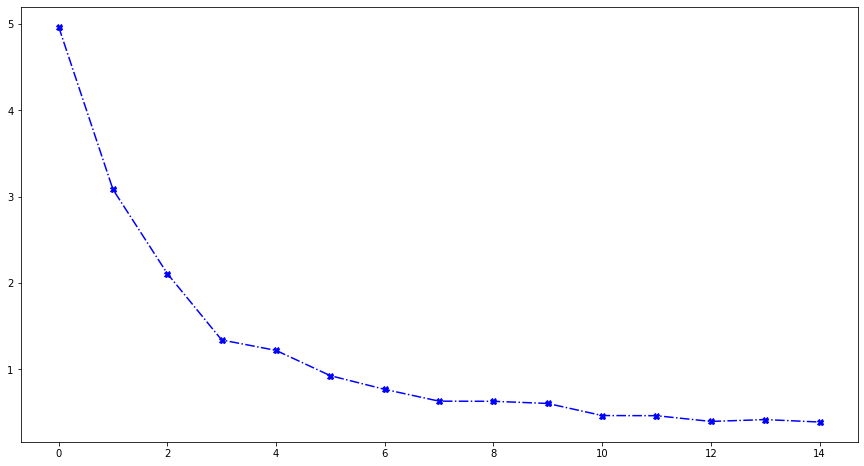

In [21]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(all_train_loss, ls='-.', marker = 'X', color='blue')

In [22]:
stop_

NameError: name 'stop_' is not defined

In [ ]:
# chk_1 =tokenizer('MaterialsComp', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=6)

In [ ]:
# tokenizer.batch_decode(chk_1['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# chk_2 =tokenizer('Ease of use', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=6)

In [ ]:
# tokenizer.batch_decode(chk_2['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# chk_ = tokenizer('Compartments', 
#           padding="max_length", 
#           truncation=True, 
#           max_length=4)

In [ ]:
# tokenizer.batch_decode(chk_['input_ids'], 
#                        skip_special_tokens=True, 
#                        clean_up_tokenization_spaces=False)

In [ ]:
electronic_topics = open('electronics_40_topics').read()
electronic_topics = electronic_topics.split('\n')

In [ ]:
electronic_topics = [x for ind, x in enumerate(electronic_topics) if ind%2==0]

In [ ]:
electronic_topics = [x.replace("'", "") for x in electronic_topics]
electronic_topics = [x.replace("[", "") for x in electronic_topics]
electronic_topics = [x.replace("]", "") for x in electronic_topics]
electronic_topics = [x.replace(",", "") for x in electronic_topics]
electronic_topics = [x.split(' ')[1:] for x in electronic_topics]

In [ ]:
electronic_topics = [x[:20] for x in electronic_topics]

In [ ]:
test_data = []
for each_e_top in electronic_topics:
    test_data.append({'seeds': each_e_top[:20], 'aspect':'TestSet'})

In [ ]:
test_dataset = aspectDataset(list_data=test_data, 
                              tokenizer=tokenizer)

In [ ]:
test_loader = DataLoader(test_dataset, 
                         batch_size=1, 
                         shuffle=True,
                         num_workers=1)

In [ ]:
model.eval()
for ind, batch in enumerate(test_loader):
    batch = {k: v.to('cuda') for k, v in batch.items()}
    model_op = model(**batch)
    print('---'*20)
    print('ID:', ind)
    print('---'*20)
    print('Seed words:', tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    print('Actual aspect:', tokenizer.batch_decode(batch['decoder_input_ids'], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    output_ids = model.generate(batch["input_ids"], num_beams=3, max_length=6)
    print('Predicted aspect:', tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True))

In [ ]:
model_op['logits'].squeeze(dim=0).shape

In [ ]:
torch.argmax(model_op['logits'].squeeze(dim=0), dim=1)

## Orphan Code
-------------

In [ ]:
print(another_way_to_train)
for epoch in range(num_epochs):
    training_loss = 0.0
    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to('cuda') for k, v in batch.items()}
        
        # Get the "input's representation"
        encoder_output = the_encoder(input_ids = batch['input_ids'],
                                   attention_mask = batch['attention_mask'])
      
        # Pass the representation + the target summary to the decoder
        decoder_output = the_decoder(input_ids=batch['decoder_input_ids'],
                                   attention_mask=batch['decoder_attention_mask'],
                                   encoder_hidden_states=encoder_output[0],
                                   encoder_attention_mask=batch['attention_mask'])

        # Use the last linear layer to predict the next token
        decoder_output = decoder_output.last_hidden_state
        lm_head_output = last_linear_layer(decoder_output)
        
        # Compute the loss
        loss = loss_fct(lm_head_output.view(-1, model.config.vocab_size),
                      batch['labels'].view(-1))
        training_loss += loss.item()
        
        loss.backward() # Update the weights
        optimizer.step() # Notify optimizer that a batch is done.
        lr_scheduler.step() # Notify the scheduler that a ...
        optimizer.zero_grad() # Reset the optimer
    training_loss = training_loss / len( train_data )
    print("Epoch {}:\tTraining Loss {:.2f}".format(epoch+1, training_loss))

In [ ]:
lm_head_output.view(-1, model.config.vocab_size)